In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from io import StringIO  
from IPython.display import Image  
import pydotplus

#import models
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from bayes_opt import BayesianOptimization

Now for the fun part of the code!  After loading in all of the necessary libraries and files, we'll be training 3 different models on the data to see which is the best at predicting.  Naturally, we need to split our data before making our models.

In [2]:
df = pd.read_json('dataframes/preprocessed_df.json')

X = df.drop(columns='bert_labels', inplace=False)
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
y = df['bert_labels']
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(y.value_counts())

1    5671
3    2949
5    2190
2    2170
4    1629
Name: bert_labels, dtype: int64


One thing to note with these y value_counts is that a label of 1 is the mode of our data, and as a result some of my models tend to overfit for it.  Since y=1 makes up about 38.188% of our data, that will be the baseline of how well the models can predict.

I'm using the below cv_score function as a way to perform k-fold validation for our various models to improve their predictions.

In [3]:
def cv_score(model, X, y, score_func):
    nfold=5
    cv = KFold(n_splits=nfold)
    if score_func == accuracy_score:
        result = cross_val_score(model, X, y, scoring=make_scorer(score_func), cv=cv)
    else:
        result = cross_val_score(model, X, y, scoring=make_scorer(score_func, average='weighted', zero_division=0), cv=cv)
    result_sum=0
    for i in result:
        result_sum+=i
    
    return (result_sum/nfold)

The first model I'm choosing to use is K Nearest Neighbors.  Ideally, similar y values will be mapped to similar vectors in X, which will allow this model to perform nicely.

In [5]:
k_max_iterations = range(1, 50) #range of hyperparameter values to test

k_accuracy_scores = []
k_precision_scores = []
k_recall_scores = []
k_F1_scores = []

for i in tqdm(k_max_iterations):
    k_accuracy_scores.append(cv_score(KNeighborsClassifier(n_neighbors=i), X, y, accuracy_score))
    k_precision_scores.append(cv_score(KNeighborsClassifier(n_neighbors=i), X, y, precision_score))
    k_recall_scores.append(cv_score(KNeighborsClassifier(n_neighbors=i), X, y, recall_score))
    k_F1_scores.append(cv_score(KNeighborsClassifier(n_neighbors=i), X, y, f1_score))

100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [1:17:37<00:00, 95.06s/it]


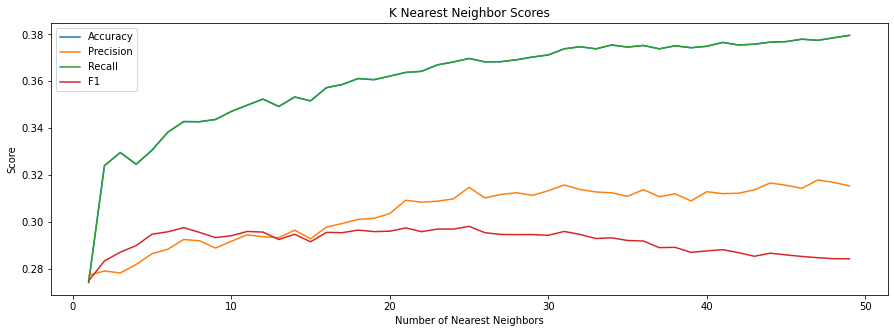

In [6]:
plt.figure(figsize=(15,5))
plt.plot(k_max_iterations, k_accuracy_scores)
plt.plot(k_max_iterations, k_precision_scores)
plt.plot(k_max_iterations, k_recall_scores)
plt.plot(k_max_iterations, k_F1_scores)
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Score')
plt.title('K Nearest Neighbor Scores')
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1'])

plt.show()

In [12]:
print(max(k_precision_scores))
k = KNeighborsClassifier(n_neighbors=50)
k.fit(X_train, y_train)
y_pred = k.predict(X_test)
print(confusion_matrix(y_pred, y_test))

0.3178927689484104
[[1248  430  573  331  463]
 [  17   21   18   11    4]
 [  69   47   64   43   34]
 [   2    2    0    1    2]
 [  81   12   61   38   81]]


K-Nearest Neighbors did not perform nearly as well as I thought it would.  I had presumed that there would be enough spread between the different y values to neatly classify, but sadly it would seem that this is not the case.  Precision tends to get worse over time, and the models gravitate towards guessing 1 for everything as k increases.

Since KNN did not perform well, I'm going to assume most linear models will not perform well either, so my next model will be a gini-impurity tree.  This will allow a decision tree to be made that operates on different parameters without needing to use all of them.  Ideally this will allow each label to have a chance of being chosen, and should theoretically become more accurate as the maximum allowed depth increases, though this will tend to overfit as it goes, so I will be trying a range of values to optimize the model.

In [13]:
maxrange=100
gini_max_iterations=range(1, maxrange)

gini_accuracy_scores = []
gini_precision_scores = []
gini_recall_scores = []
gini_F1_scores = []

for i in tqdm(gini_max_iterations):
    gini_accuracy_scores.append(cv_score(tree.DecisionTreeClassifier(criterion='gini', max_depth=i), X, y, accuracy_score))
    gini_precision_scores.append(cv_score(tree.DecisionTreeClassifier(criterion='gini', max_depth=i), X, y, precision_score))
    gini_recall_scores.append(cv_score(tree.DecisionTreeClassifier(criterion='gini', max_depth=i), X, y, recall_score))
    gini_F1_scores.append(cv_score(tree.DecisionTreeClassifier(criterion='gini', max_depth=i), X, y, f1_score))

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [04:50<00:00,  2.94s/it]


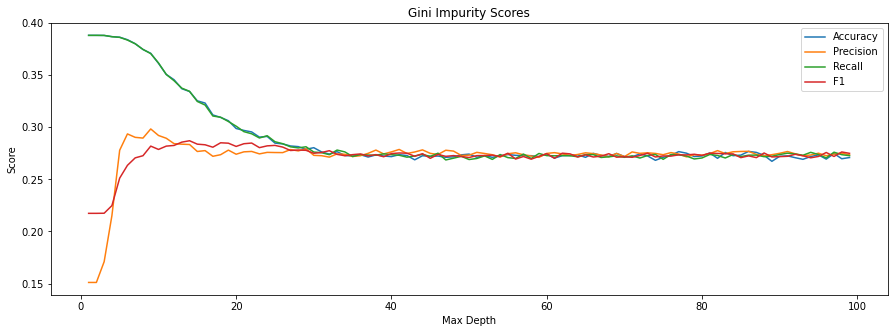

In [14]:
plt.figure(figsize=(15,5))
plt.plot(gini_max_iterations[0:maxrange], gini_accuracy_scores[0:maxrange])
plt.plot(gini_max_iterations[0:maxrange], gini_precision_scores[0:maxrange])
plt.plot(gini_max_iterations[0:maxrange], gini_recall_scores[0:maxrange])
plt.plot(gini_max_iterations[0:maxrange], gini_F1_scores[0:maxrange])
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Gini Impurity Scores')
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1'])

plt.show()

8 0.2983611816404925


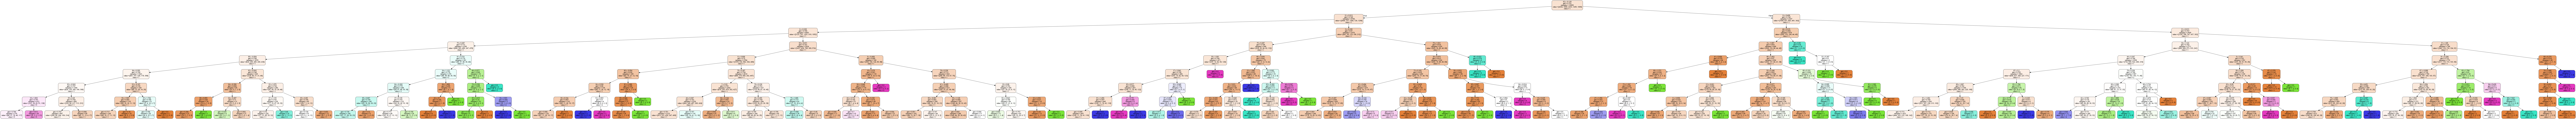

In [15]:
dot_data = StringIO()

best_precision = max(gini_precision_scores)
best_precision_index = gini_precision_scores.index(best_precision)

print(best_precision_index, best_precision)

best_gini = tree.DecisionTreeClassifier(criterion='gini', max_depth=best_precision_index)
best_gini.fit(X_train, y_train)

X_train = pd.DataFrame(X_train)
tree.export_graphviz(best_gini, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ['1', '2', '3', '4', '5']) 

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Much like the K Nearest Neighbors Classifier, it seems that the gini model overfits for the value of 1, which is made more obvious by the fact that the highest recall score is at max_depth = 1.  This model gives the other values a chance at least, but at the cost of getting a lower precision score.

Since my main problem seems to be a lack of linear closeness between matching y values, my last model is going to be a gradient boosted classifier, so that the model can learn from it's mistakes.  Unlike the previous two models, I have multiple hyperparameters that I'm going to be adjusting, so I will run it through a Bayesian optimizer to increase its effectiveness.

In [16]:
def gradient_boost(n_estimators, learning_rate, max_features, max_depth):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, 
                                    max_features=max_features, max_depth=max_depth, random_state=1020)
    gb.fit(X_train, y_train)
    return(gb.score(X_test, y_test))

In [17]:
optimizer = BayesianOptimization(gradient_boost, {'n_estimators':(1, 250), 'learning_rate':(0.01, 1.0), 
                                                  'max_features':(0.01, 1.0), 'max_depth':(1, 100)})
optimizer.maximize(n_iter=100, init_points=2)
print(optimizer.max)

|   iter    |  target   | learni... | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.3748   |  0.7402   |  23.62    |  0.8409   |  235.1    |
|  2        |  0.3197   |  0.6144   |  66.7     |  0.9667   |  200.7    |
|  3        |  0.3712   |  0.5121   |  23.13    |  0.5395   |  234.0    |
|  4        |  0.3548   |  1.0      |  30.38    |  1.0      |  249.5    |
|  5        |  0.3416   |  0.9843   |  15.94    |  0.8982   |  243.1    |
|  6        |  0.3644   |  0.8471   |  31.62    |  0.9248   |  236.1    |
|  7        |  0.3786   |  0.612    |  33.06    |  0.7421   |  222.6    |
|  8        |  0.3704   |  0.1135   |  35.53    |  0.7784   |  214.9    |
|  9        |  0.3767   |  1.0      |  41.5     |  0.01     |  223.8    |
|  10       |  0.3789   |  0.8962   |  23.26    |  0.2476   |  216.3    |
|  11       |  0.3616   |  1.0      |  21.63    |  1.0      |  206.5    |
|  12       |  0.3592   |  0.9602   | 

|  67       |  0.3824   |  0.7206   |  22.2     |  0.2637   |  126.2    |
|  68       |  0.3879   |  0.01     |  1.0      |  0.01     |  91.35    |
|  69       |  0.3879   |  0.4958   |  2.311    |  0.01652  |  4.368    |
|  70       |  0.3879   |  0.01     |  8.099    |  1.0      |  7.853    |
|  71       |  0.3436   |  0.5406   |  13.4     |  0.9443   |  1.1      |
|  72       |  0.3928   |  0.09714  |  1.085    |  0.7218   |  208.7    |
|  73       |  0.3986   |  0.02957  |  7.112    |  0.3656   |  206.3    |
|  74       |  0.3515   |  0.4496   |  6.054    |  0.5092   |  211.8    |
|  75       |  0.3939   |  0.7997   |  1.05     |  0.6311   |  59.44    |
|  76       |  0.3876   |  0.1553   |  5.759    |  0.6667   |  56.88    |
|  77       |  0.3898   |  0.0801   |  7.471    |  0.6509   |  86.96    |
|  78       |  0.3994   |  0.6899   |  1.966    |  0.9344   |  82.94    |
|  79       |  0.3356   |  0.6698   |  7.027    |  0.2697   |  79.51    |
|  80       |  0.3972   |  0.4407   | 

In [20]:
gb = GradientBoostingClassifier(n_estimators=171, learning_rate=0.27708, 
                                max_depth=1, max_features=0.754715, random_state=1020)
gb.fit(X_train, y_train)
print('Training Score: ', gb.score(X_train, y_train))
print('Testing Score: ', gb.score(X_test, y_test))

Training Score:  0.41228550565899963
Testing Score:  0.4018614837120175


In [21]:
y_pred = gb.predict(X_test)
print(confusion_matrix(y_pred, y_test))

[[1303  420  585  344  498]
 [  45   63   46   34   15]
 [  33   20   51   27   23]
 [   2    2    4    5    2]
 [  34    7   30   14   46]]


This model does slightly better than chance, even if only by about 2%.  This ends up being the most accurate model out of the three, though it is still overfitting for y=1.  The model does take some time to optimize the hyperparameters, but the actual time it takes to fit is somewhere between the other two models and about equal in prediction speed, which is worth the slight accuracy boost.  Since this model takes the time to learn from previous mistakes on data with seemingly no linear pattern, it ends up being the best model to predict on this data.